In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

In [20]:
from josie.bc import Dirichlet, Neumann, NeumannDirichlet
from josie.geom import Line
from josie.solver.euler import Q, EulerSolver, PerfectGas, Rusanov
from josie.mesh import Mesh, SimpleCell

left = Line([0, 0], [0, 1])
bottom = Line([0, 0], [1, 0])
right = Line([1, 0], [1, 1])
top = Line([0, 1], [1, 1])

eos = PerfectGas(gamma=1.4)

# Params
JET_CENTER = 0.5
JET_RADIUS = 0.05

# Inlet
U_JET = 1
V_JET = 0
RHO_JET = 2
P_JET = 10

RHOe_JET = eos.rhoe(RHO_JET, P_JET)
E_JET = RHOe_JET/RHO_JET + 0.5 * (U_JET**2 + V_JET**2)
C_JET = eos.sound_velocity(RHO_JET, P_JET)
print(f"Mach: {U_JET/C_JET}")
Q_JET = Q(RHO_JET, RHO_JET*U_JET, RHO_JET*V_JET, RHO_JET*E_JET, RHOe_JET, U_JET, V_JET, P_JET, C_JET)

# Field conditions at init
U_INIT = 0
V_INIT = 0
RHO_INIT = 1
P_INIT = 5
RHOe_INIT = eos.rhoe(RHO_INIT, P_INIT)
E_INIT = RHOe_INIT/RHO_INIT + 0.5 * (U_INIT**2 + V_INIT**2)
C_INIT = eos.sound_velocity(RHO_INIT, P_INIT)

print(f"Mach: {U_INIT/C_INIT}")

Q_INIT = Q(RHO_INIT, RHO_INIT*U_INIT, RHO_INIT*V_INIT, RHO_INIT*E_INIT, RHOe_INIT, 
           U_INIT, V_INIT, P_INIT, C_INIT)

# Neumann
dQ = Q.zeros()

def partition_fun(centroids: np.ndarray):
    yc = centroids[:, 1]
    
    # Partition cells of the inlet
    idx = np.where((yc - JET_CENTER)**2 < JET_RADIUS**2)
    
    print(idx)
    return idx


# Assign BC to boundaries
# left.bc = NeumannDirichlet(dirichlet_value=Q_JET, neumann_value=dQ, partition_fun=partition_fun)
left.bc = Dirichlet(Q_JET)
top.bc = Neumann(dQ)
right.bc = Neumann(dQ)
bottom.bc = Neumann(dQ)

mesh = Mesh(left, bottom, right, top, SimpleCell)
mesh.interpolate(3, 3)
mesh.generate()
mesh.write('mesh.xdmf')
# mesh.plot()

Mach: 0.3779644730092272
Mach: 0.0


In [21]:
# Solver
solver = EulerSolver(mesh, eos)



def init_fun(solver): 
    solver.values[:, :, :] = Q_INIT
    

solver.init(init_fun)
solver.save(0, 'euler.xdmf')

In [22]:
print(solver.left_ghost[:, 0])
print(solver.mesh.centroids[0, :, 1])

[3. 3. 3.]
[0.16666667 0.5        0.83333333]


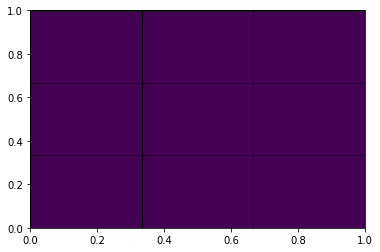

In [23]:
solver.plot()
solver.show('rhoU')

In [ ]:
final_time = 0.25
t = 0
CFL = 0.2
scheme = Rusanov()

while t <= final_time:
    dt = scheme.CFL(
        solver.values, 
        solver.mesh.volumes, 
        solver.mesh.normals,
        solver.mesh.surfaces,
        CFL,
    )
    solver.step(dt, scheme)
    t += dt
    print(f't: {t}, dt: {dt}')
    solver.save(t, 'euler.xdmf')


del solver._writer

> /work/irlin361755_1/home/dibattir/git/josiepy/josie/solver/euler/schemes.py(107)convective_flux()
    106 
--> 107         FS[:, :, :4] = surfaces[:, :, np.newaxis] * (DeltaF - DeltaQ)
    108 

ipdb> p DeltaF - DeltaQ
array([[[-6.64575131e+00, -2.32915026e+01,  0.00000000e+00,
         -1.17217643e+02],
        [-6.64575131e+00, -2.32915026e+01,  0.00000000e+00,
         -1.17217643e+02],
        [-6.64575131e+00, -2.32915026e+01,  0.00000000e+00,
         -1.17217643e+02]],

       [[ 0.00000000e+00, -5.00000000e+00,  1.66533454e-15,
          0.00000000e+00],
        [ 0.00000000e+00, -5.00000000e+00, -2.49800181e-15,
          0.00000000e+00],
        [ 0.00000000e+00, -5.00000000e+00,  8.32667268e-16,
          0.00000000e+00]],

       [[ 0.00000000e+00, -5.00000000e+00,  3.33066907e-15,
          0.00000000e+00],
        [ 0.00000000e+00, -5.00000000e+00, -4.99600361e-15,
          0.00000000e+00],
        [ 0.00000000e+00, -5.00000000e+00,  1.66533454e-15,
          0.0000000

In [20]:
del solver._writer

AttributeError: _writer

In [7]:
print(Q_JET)

[ 2.          2.          0.         26.         25.          1.
  0.         10.          2.64575131]


In [11]:
print(Q_INIT)

[ 1.          0.          0.         12.5        12.5         0.
  0.          5.          2.64575131]


In [16]:
print(solver.left_ghost[0, :].ravel())

[ 3.          4.          0.         39.5        37.5         2.
  0.         15.          2.64575131]
